# Análise e predição de atrasos em compras on-line
-----------
### Criação de um modelo de aprendizado de máquina para ajudar a prever atrasos em entregas de compras em uma loja on-line com o objetivo de aumentar a retenção de clientes.

## 1. Introdução

In [543]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from utils import standardise_column_names, plot_boxplots, distribution_plot

chain = pd.read_csv('supply_chain.csv', encoding='latin-1')
chain = standardise_column_names(chain)
chain.head(10)

,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,order_zipcode,product_card_id,product_category_id,product_description,product_image,product_name,product_price,product_status,shipping_date_dateorders,shipping_mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class
5,TRANSFER,6,4,18.580000,294.980011,Shipping canceled,0,73,Sporting Goods,Tonawanda,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/19/2018 11:03,Standard Class
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 10:42,First Class
7,TRANSFER,2,1,68.430000,285.140015,Late delivery,1,73,Sporting Goods,Miami,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 10:21,First Class
8,CASH,3,2,133.720001,278.589996,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 10:00,Second Class
9,CASH,2,1,132.149994,275.309998,Late delivery,1,73,Sporting Goods,San Ramon,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 9:39,First Class


In [544]:
chain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   type                         180519 non-null  object 
 1   days_for_shipping_real       180519 non-null  int64  
 2   days_for_shipment_scheduled  180519 non-null  int64  
 3   benefit_per_order            180519 non-null  float64
 4   sales_per_customer           180519 non-null  float64
 5   delivery_status              180519 non-null  object 
 6   late_delivery_risk           180519 non-null  int64  
 7   category_id                  180519 non-null  int64  
 8   category_name                180519 non-null  object 
 9   customer_city                180519 non-null  object 
 10  customer_country             180519 non-null  object 
 11  customer_email               180519 non-null  object 
 12  customer_fname               180519 non-null  object 
 13 

In [545]:
chain.delivery_status.unique()

array(['Advance shipping', 'Late delivery', 'Shipping on time',
       'Shipping canceled'], dtype=object)

In [546]:
chain.delivery_status.value_counts()

Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled     7754
Name: delivery_status, dtype: int64

In [547]:
constant_columns = [col for col in chain.columns if chain[col].nunique() == 1]
# every column that endswith "id"
id_columns = [col for col in chain.columns if col.endswith('id')]
not_wanted_columns = ['product_image', 'product_description'] + id_columns


data = chain.drop(columns=not_wanted_columns + constant_columns)
data.head()

,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_name,customer_city,customer_country,...,order_item_total,order_profit_per_order,order_region,order_state,order_status,order_zipcode,product_name,product_price,shipping_date_dateorders,shipping_mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,...,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,Smart watch,327.75,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,Sporting Goods,Caguas,Puerto Rico,...,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,Smart watch,327.75,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,Sporting Goods,San Jose,EE. UU.,...,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,Smart watch,327.75,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,Sporting Goods,Los Angeles,EE. UU.,...,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,Smart watch,327.75,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,Sporting Goods,Caguas,Puerto Rico,...,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,Smart watch,327.75,1/15/2018 11:24,Standard Class


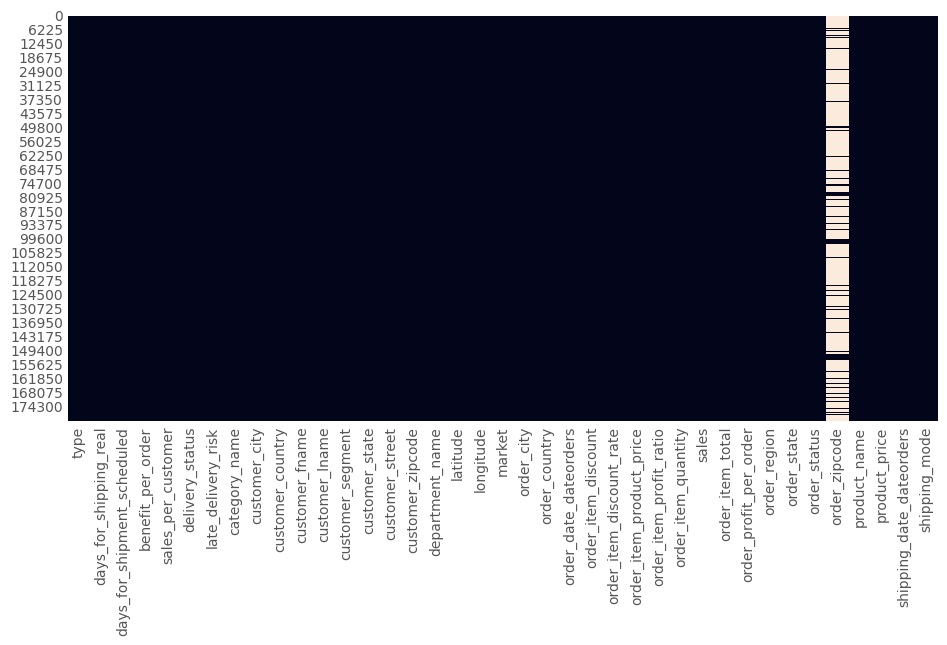

In [548]:
# nan matrix
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull(), cbar=False)
plt.show()

In [549]:
# drop zip code
data = data.drop(columns=['order_zipcode'])

In [550]:
cat_cols = data.select_dtypes(include='object').columns.tolist()
num_cols = data.select_dtypes(include='number').columns.tolist()

# print columns names with index numbers and make a line with 3 column names and then break line
print("Categorical Columns: ")
for i, col in enumerate(cat_cols, 1):
    print(f'{i:2}. {col:20}', end='\t')
    if i % 3 == 0:
        print()

print("\nNumerical Columns: ")
for i, col in enumerate(num_cols, 1):
    print(f'{i:2}. {col:20}', end='\t')
    if i % 3 == 0:
        print()


Categorical Columns: 
 1. type                	 2. delivery_status     	 3. category_name       	
 4. customer_city       	 5. customer_country    	 6. customer_fname      	
 7. customer_lname      	 8. customer_segment    	 9. customer_state      	
10. customer_street     	11. department_name     	12. market              	
13. order_city          	14. order_country       	15. order_date_dateorders	
16. order_region        	17. order_state         	18. order_status        	
19. product_name        	20. shipping_date_dateorders	21. shipping_mode       	

Numerical Columns: 
 1. days_for_shipping_real	 2. days_for_shipment_scheduled	 3. benefit_per_order   	
 4. sales_per_customer  	 5. late_delivery_risk  	 6. customer_zipcode    	
 7. latitude            	 8. longitude           	 9. order_item_discount 	
10. order_item_discount_rate	11. order_item_product_price	12. order_item_profit_ratio	
13. order_item_quantity 	14. sales               	15. order_item_total    	
16. order_profit_per

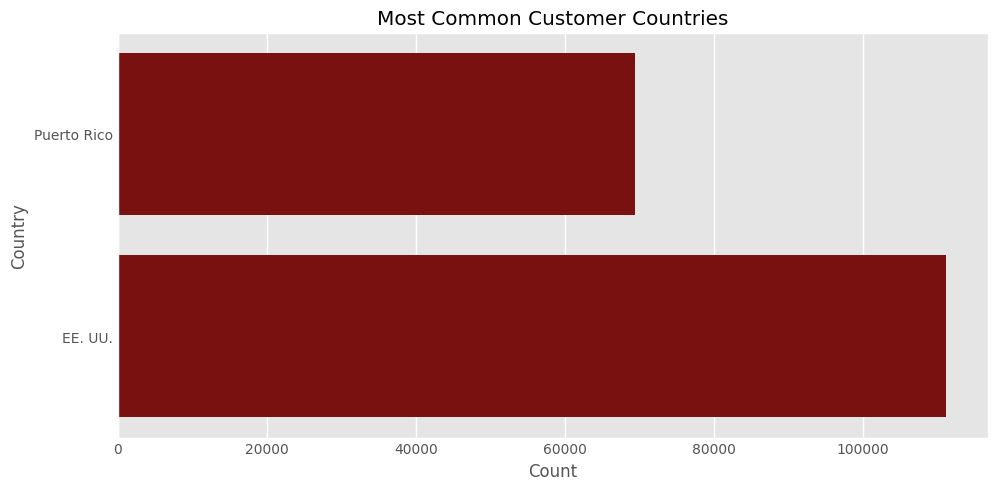

In [551]:
# plot the most common customer countries using seaborn

plt.figure(figsize=(10, 5))
sns.countplot(data=data, y='customer_country', color='darkred')
plt.title('Most Common Customer Countries')
plt.xlabel('Count')
plt.ylabel('Country')
plt.savefig('customer_countries.png', dpi=300)

plt.show()


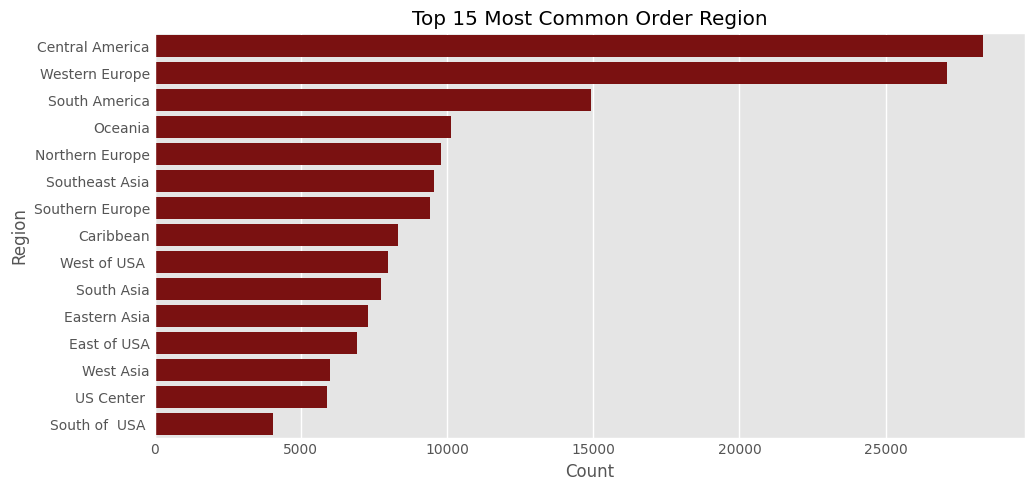

In [552]:

plt.figure(figsize=(10, 5))
sns.countplot(data=data, y=data.order_region, color='darkred', order=data.order_region.value_counts().index[:15])
plt.title('Top 15 Most Common Order Region')

plt.xlabel('Count')
plt.ylabel('Region')
plt.savefig('top_15_order_regions.png', dpi=300)

plt.show()


In [553]:
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
days_for_shipping_real,180519.0,3.497654,1.623722,0.000000,2.000000,3.000000,5.000000,6.000000
days_for_shipment_scheduled,180519.0,2.931847,1.374449,0.000000,2.000000,4.000000,4.000000,4.000000
benefit_per_order,180519.0,21.974989,104.433526,-4274.979980,7.000000,31.520000,64.800003,911.799988
sales_per_customer,180519.0,183.107609,120.043670,7.490000,104.379997,163.990005,247.399994,1939.989990
late_delivery_risk,180519.0,0.548291,0.497664,0.000000,0.000000,1.000000,1.000000,1.000000
customer_zipcode,180516.0,35921.126914,37542.461122,603.000000,725.000000,19380.000000,78207.000000,99205.000000
latitude,180519.0,29.719955,9.813646,-33.937553,18.265432,33.144863,39.279617,48.781933
longitude,180519.0,-84.915675,21.433241,-158.025986,-98.446312,-76.847908,-66.370583,115.263077
order_item_discount,180519.0,20.664741,21.800901,0.000000,5.400000,14.000000,29.990000,500.000000
order_item_discount_rate,180519.0,0.101668,0.070415,0.000000,0.040000,0.100000,0.160000,0.250000


### Algumas observações
- A loja é de roupa, esportes e componentes eletrônicos.
- Vamos assumir que a moeda é o **dólar americano**.
- `benefit_per_order`: lucro por pedido. Temos desde um prejuízo de **4275.0** dólares até um positivo de **911.8** dólares.
- `product_price`: não tem itens muito caros, o mais caro é de **2 mil**.
- `order_item_quantity`: poucas quantidades por item
- `days_for_shipping_real` é **maior** em média do que o `days_for_shipment_scheduled`, indicando atrasos
- `late_delivery_risk`: indica se a entrega foi enviada com atraso (`days_for_shipping_real` > `days_for_shipment_scheduled`). Média de **0.54**, confirmando a observação anterior.
- `latitude` e `longitude` indicando as localidades das lojas de onde partem os pedidos

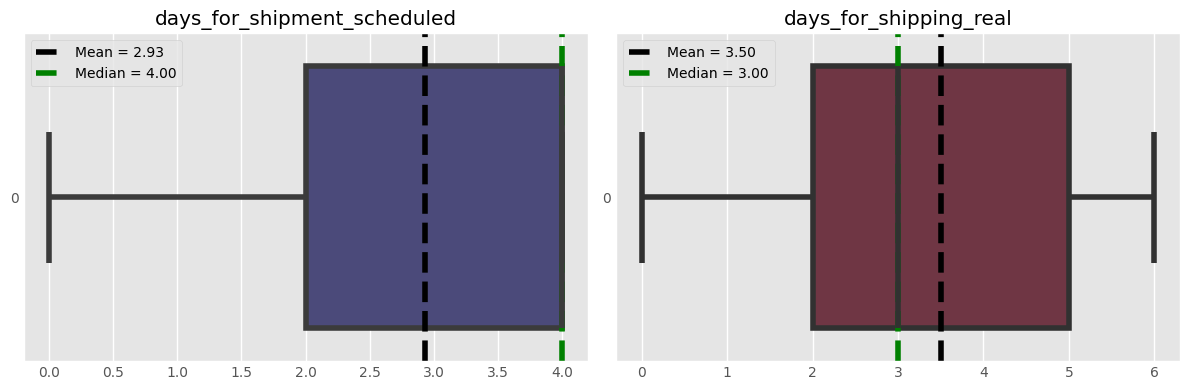

In [554]:
plot_boxplots(data, ['days_for_shipment_scheduled', 'days_for_shipping_real'])

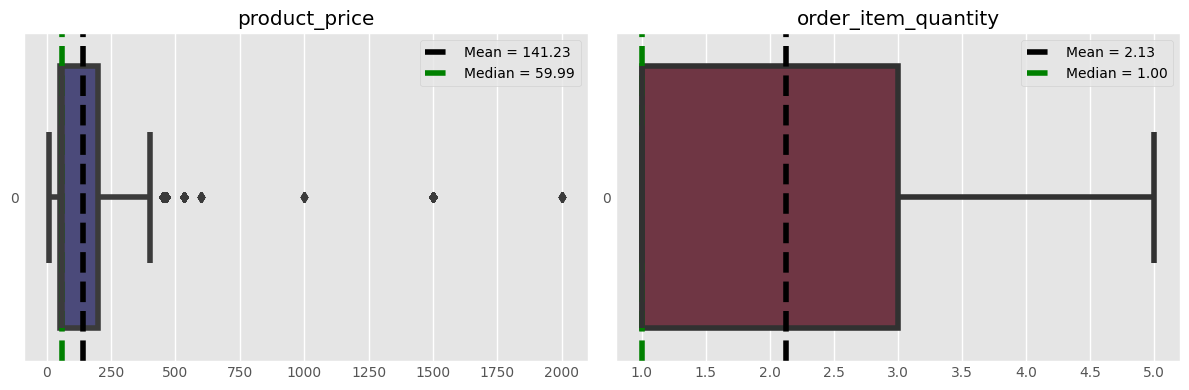

In [555]:
plot_boxplots(data, ['product_price', 'order_item_quantity'])

Alguns outliers nos preços dos produtos

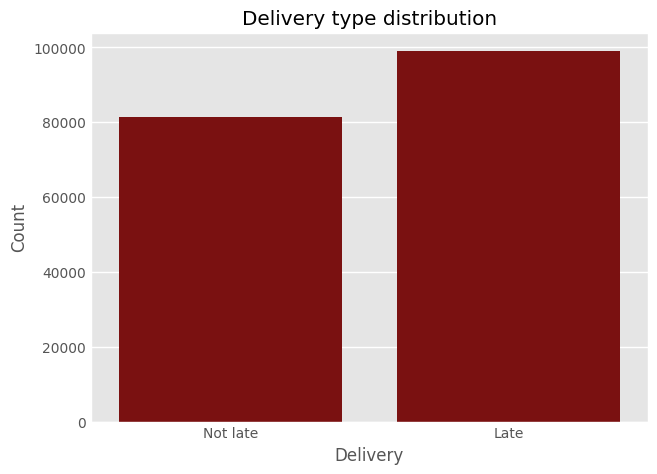

In [556]:
sns.countplot(data=data.assign(late_cat = data.late_delivery_risk.map({0: "Not late", 1: "Late"})), x='late_cat', color='darkred')
plt.title('Delivery type distribution')
plt.xlabel('Delivery')
plt.ylabel('Count')
plt.savefig('late_delivery_risk.png', dpi=300, bbox_inches='tight')
plt.show()


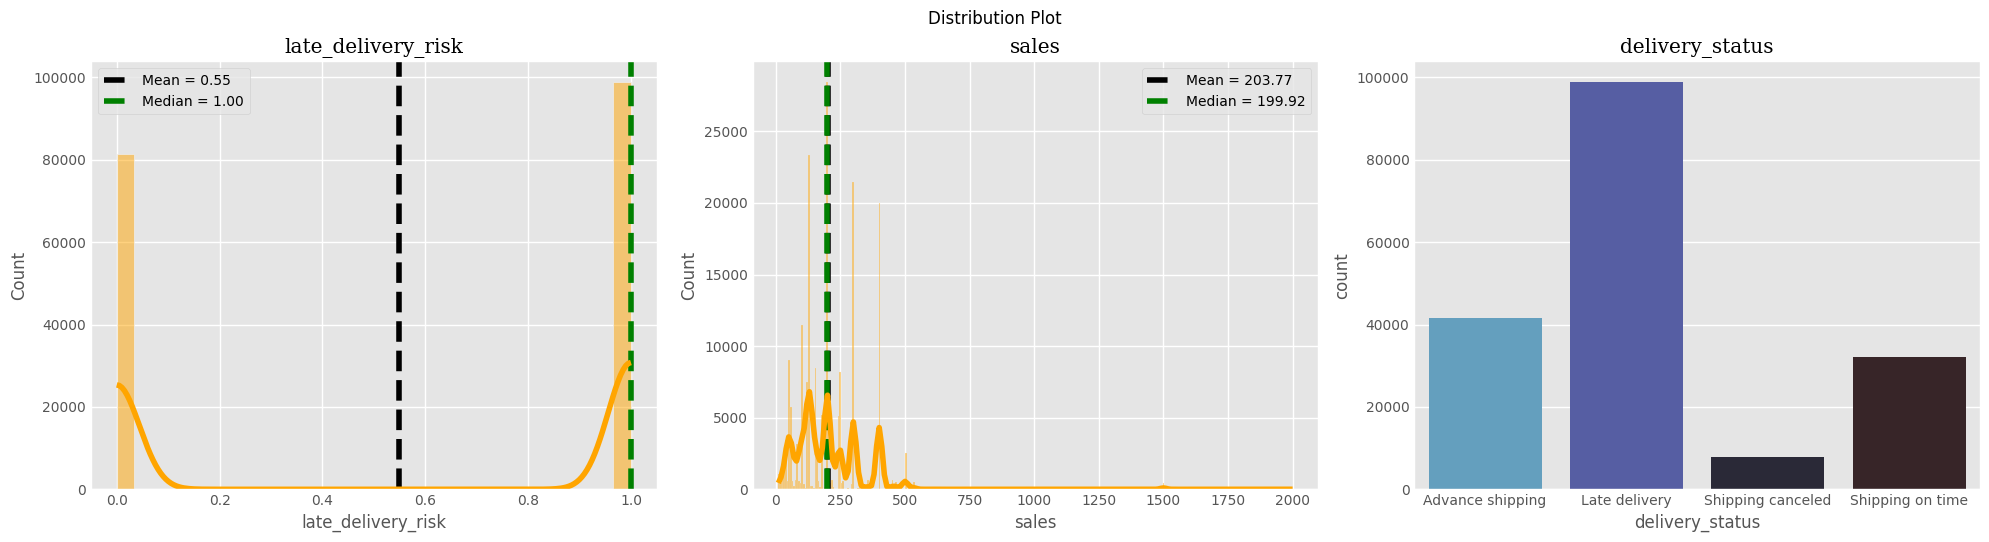

In [557]:
distribution_plot(data, include_columns=['late_delivery_risk','delivery_status', 'sales'])

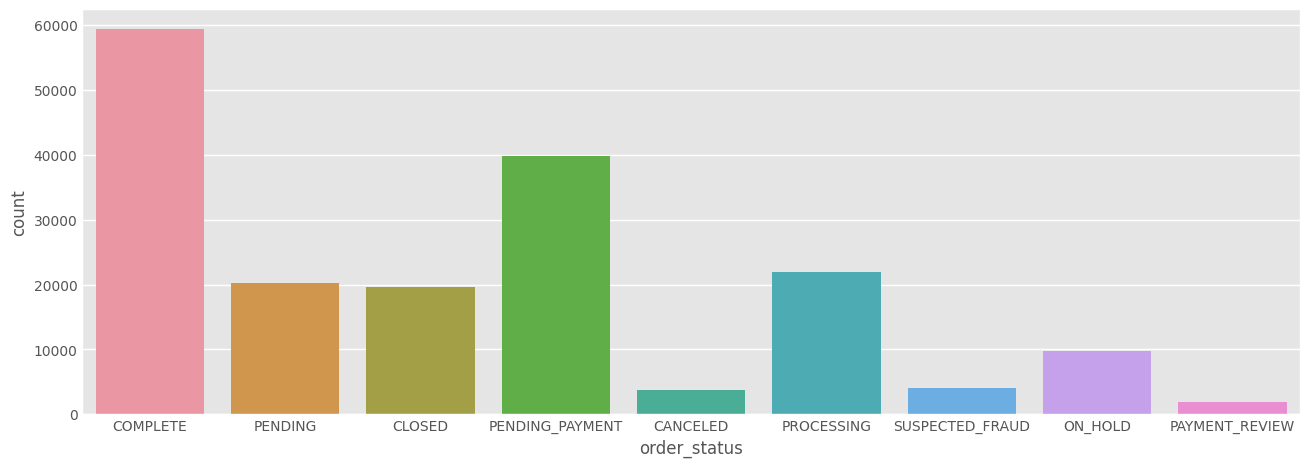

In [558]:
_ = plt.figure(figsize=(14, 5))
_ = sns.countplot(data=data, x='order_status')

## Análise Multivariada

In [559]:
data['late_delivery_risk_cat'] = data['late_delivery_risk'].map({1: "Late", 0: "Not late"})

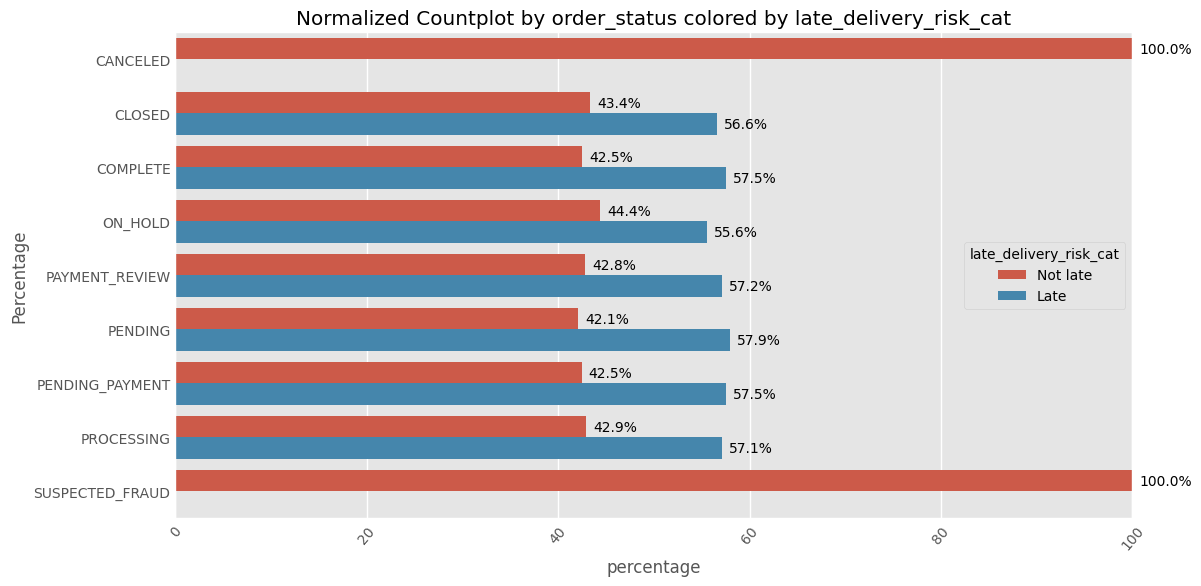

In [560]:
from utils import plot_norm_countplot

plt.figure(figsize=(11, 6))
plot_norm_countplot(data, 'order_status', 'late_delivery_risk_cat', horizontal=True)

Exceto nos extremos de compras canceladas e de suspeitas de fraude, a proporção de entregas que foram enviadas atrasadas não parece ser significante, pois foi visto anteriormente que o dataset possui mais entregas atrasadas no geral.

In [561]:
fraud_or_canceled = data[(data.order_status == 'SUSPECTED_FRAUD') | (data.order_status == 'CANCELED')]
data = data.drop(fraud_or_canceled.index)

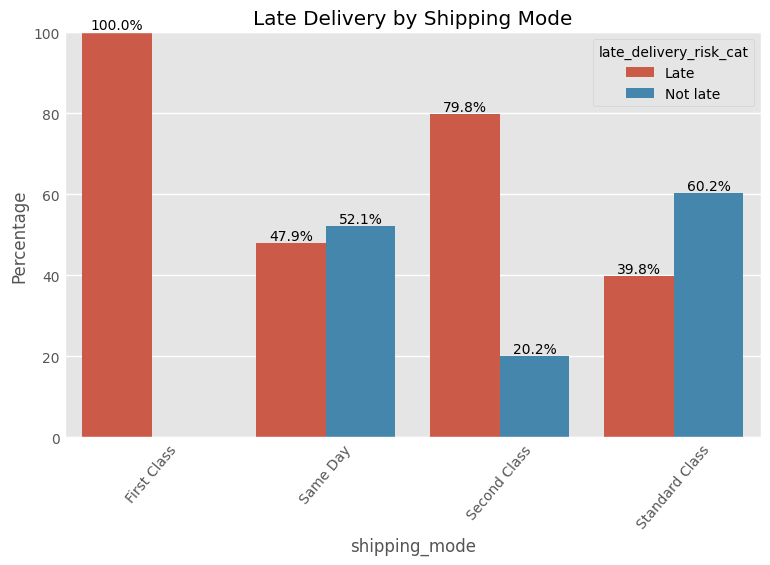

In [562]:
plt.figure(figsize=(8, 5))
plot_norm_countplot(data, 'shipping_mode', 'late_delivery_risk_cat', title='Late Delivery by Shipping Mode')

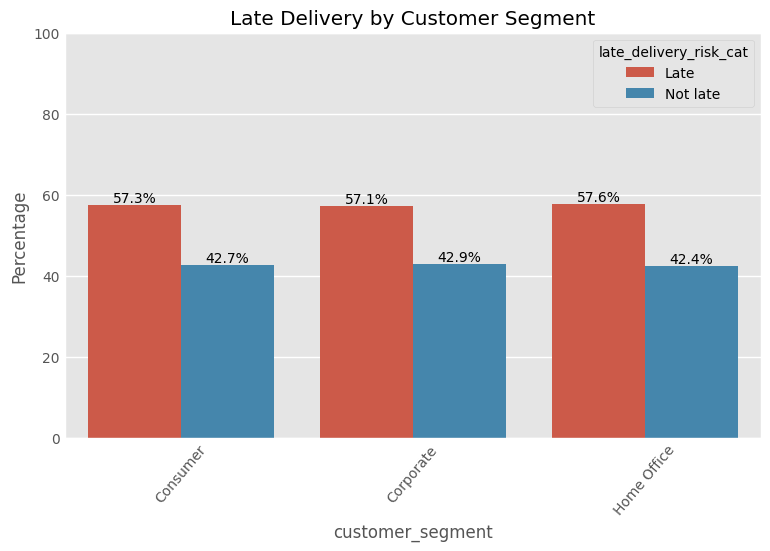

In [563]:
plt.figure(figsize=(8, 5))
plot_norm_countplot(data, 'customer_segment', 'late_delivery_risk_cat', title='Late Delivery by Customer Segment')

In [564]:
# top 10 most "delivery late" products normalized by the total number of orders of that product
# add the price of the product too
top_10_late_delivery_products = late_delivery.product_name.value_counts(normalize=True).head(10).reset_index(name='late_percentage')
top_10_late_delivery_products.rename(columns={'index': 'product_name'}, inplace=True)
top_10_late_delivery_products['product_price'] = late_delivery.groupby('product_name').agg({'product_price': 'mean'}).reset_index()['product_price'].head(10)
top_10_late_delivery_products

,product_name,late_percentage,product_price
0,Perfect Fitness Perfect Rip Deck,0.143230,24.990000
1,Nike Men's CJ Elite 2 TD Football Cleat,0.128524,79.989998
2,Nike Men's Dri-FIT Victory Golf Polo,0.121526,31.990000
3,O'Brien Men's Neoprene Life Vest,0.112100,31.990000
4,Field & Stream Sportsman 16 Gun Fire Safe,0.100684,31.990000
5,Pelican Sunstream 100 Kayak,0.089914,89.989998
6,Diamondback Women's Serene Classic Comfort Bi,0.079176,209.990005
7,Nike Men's Free 5.0+ Running Shoe,0.070188,119.989998
8,Under Armour Girls' Toddler Spine Surge Runni,0.062086,9.990000
9,Team Golf St. Louis Cardinals Putter Grip,0.002154,39.990002


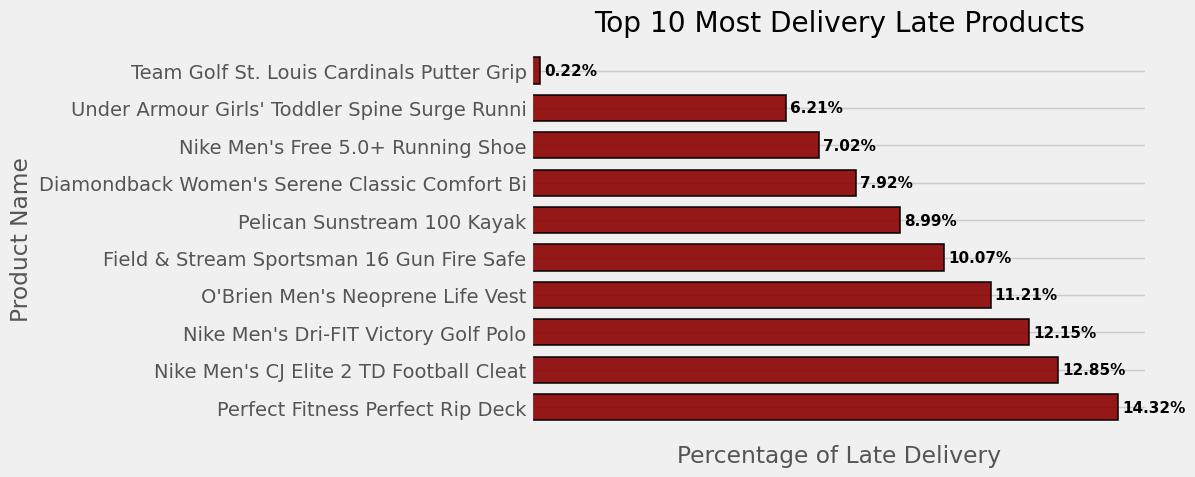

In [565]:
#plot the top 10 most "delivery late" products normalized by the total number of orders
# annotate the values on the bars. the value should be inside the bar and rounded to 2 decimal places
import matplotlib.style as style
style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))
# add another dimension to the cart using color gradient
plt.barh(top_10_late_delivery_products.product_name, top_10_late_delivery_products.late_percentage, color='darkred',
         edgecolor='black', linewidth=1.2, alpha=0.9, height=0.7)
for i, v in enumerate(top_10_late_delivery_products.late_percentage):
    plt.text(v+0.001, i, f'{v*100:.2f}%', va='center', fontweight='bold', color='black', fontsize=11)

plt.xticks([])
plt.title("Top 10 Most Delivery Late Products", loc='center')
plt.xlabel("Percentage of Late Delivery")
plt.ylabel("Product Name")
plt.tight_layout()

# save figure
plt.savefig('top_10_most_delivery_late_products.png', dpi=300)
plt.show()

In [566]:
top_10_late_delivery_categories = late_delivery.category_name.value_counts(normalize=True).head(10).reset_index(name='late_percentage')
top_10_late_delivery_categories.rename(columns={'index': 'product_category_name'}, inplace=True)
top_10_late_delivery_categories

,product_category_name,late_percentage
0,Cleats,0.143230
1,Men's Footwear,0.128524
2,Women's Apparel,0.121526
3,Indoor/Outdoor Games,0.112100
4,Fishing,0.100684
5,Water Sports,0.089914
6,Camping & Hiking,0.079176
7,Cardio Equipment,0.072113
8,Shop By Sport,0.064174
9,Electronics,0.019354


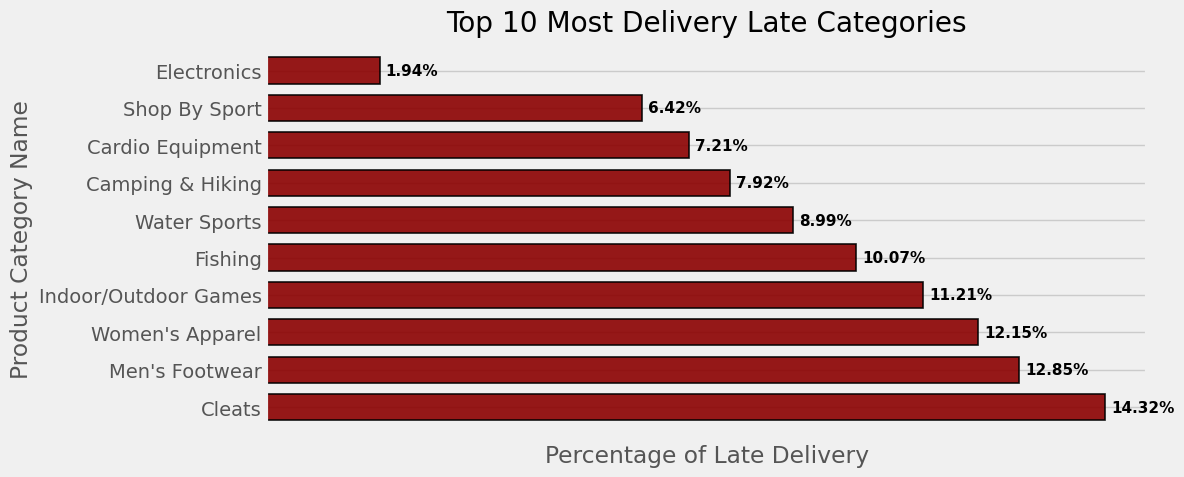

In [567]:
# plot top 10 most delivery late categories
plt.figure(figsize=(12, 5))
plt.barh(top_10_late_delivery_categories.product_category_name, top_10_late_delivery_categories.late_percentage, color='darkred',
            edgecolor='black', linewidth=1.2, alpha=0.9, height=0.7)
for i, v in enumerate(top_10_late_delivery_categories.late_percentage):
    plt.text(v+0.001, i, f'{v*100:.2f}%', va='center', fontweight='bold', color='black', fontsize=11)

plt.xticks([])
plt.title("Top 10 Most Delivery Late Categories", loc='center')
plt.xlabel("Percentage of Late Delivery")
plt.ylabel("Product Category Name")
plt.tight_layout()

# save figure
plt.savefig('top_10_most_delivery_late_categories.png', dpi=300)
plt.show()


Os produtos que são mais entregues com atraso são tênis e roupas esportivas.

In [568]:
#plot the top 10 most "delivery late" order cities normalized by the total number of orders of that city. Add the price of the item too
top_10_late_cities = late_delivery.customer_city.value_counts(normalize=True).head(10)
top_10_late_cities

Caguas          0.368612
Chicago         0.022394
Los Angeles     0.018610
Brooklyn        0.018446
New York        0.010311
Philadelphia    0.009010
Bronx           0.008223
San Diego       0.007862
Miami           0.007140
Houston         0.006834
Name: customer_city, dtype: float64

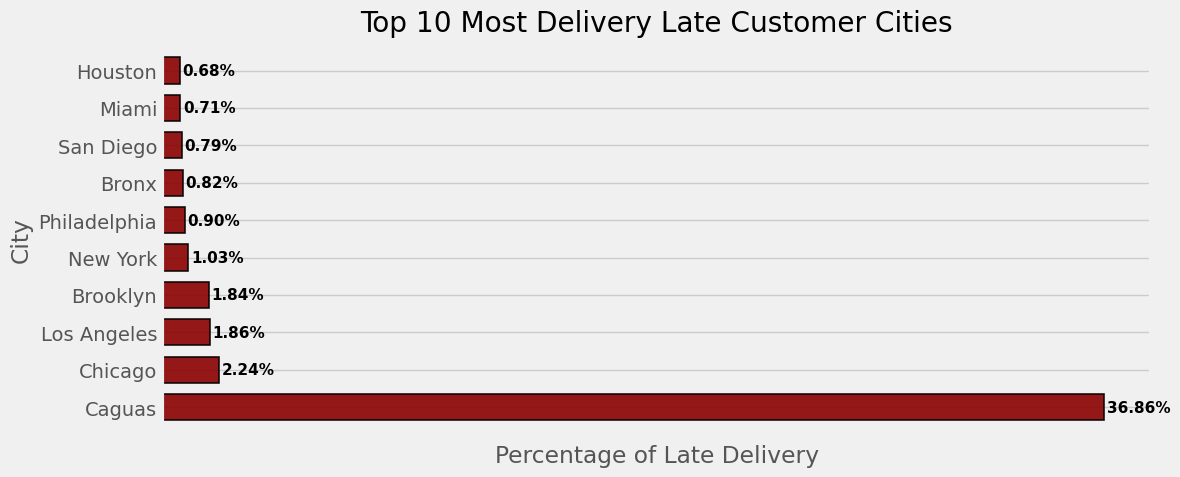

In [569]:
# plot
style.use('fivethirtyeight')
plt.figure(figsize=(12, 5))
plt.barh(top_10_late_cities.index, top_10_late_cities.values, color='darkred',
         edgecolor='black', linewidth=1.2, alpha=0.9, height=0.7)
for i, v in enumerate(top_10_late_cities.values):
    plt.text(v+0.001, i, f'{v*100:.2f}%', va='center', fontweight='bold', color='black', fontsize=11)

plt.xticks([])
plt.title("Top 10 Most Delivery Late Customer Cities", loc='center')
plt.xlabel("Percentage of Late Delivery")
plt.ylabel("City")
plt.tight_layout()

# save figure
plt.savefig('top_10_most_delivery_late_cities.png', dpi=300)

## Engenharia de Recursos
----------

In [570]:
data['order_date'] = pd.to_datetime(data['order_date_dateorders'])

In [571]:
data = data.assign(order_hour=data.order_date.dt.hour, order_day=data.order_date.dt.day, order_month=data.order_date.dt.month, order_year=data.order_date.dt.year)

In [572]:
late_delivery = data[data.late_delivery_risk == 1].set_index('order_date')

late_delivery_by_year_month = late_delivery.resample('M').size()
late_delivery_by_year_month.head()

order_date
2015-01-31    2880
2015-02-28    2594
2015-03-31    2936
2015-04-30    2760
2015-05-31    2951
Freq: M, dtype: int64

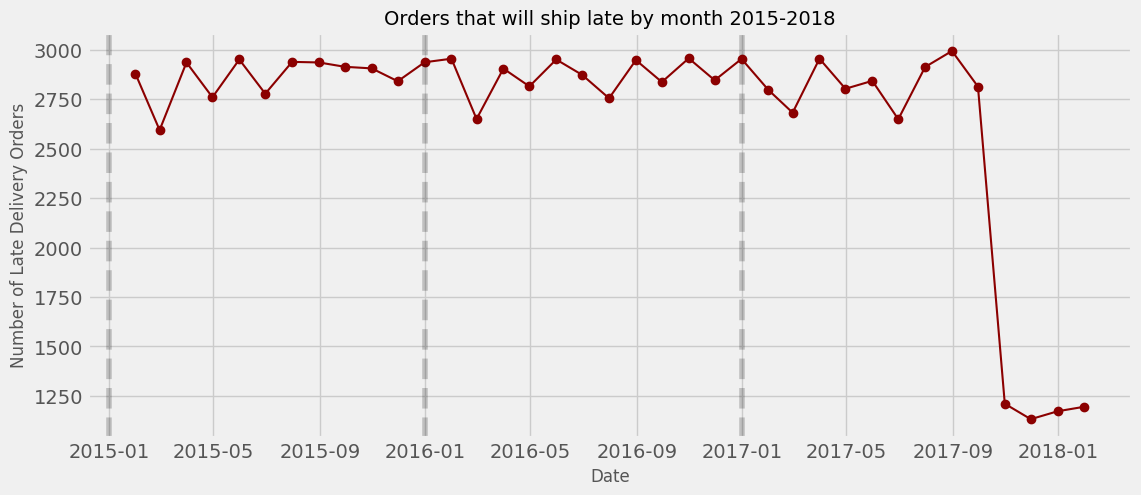

In [573]:
plt.figure(figsize=(12, 5))
plt.plot(late_delivery_by_year_month, color='darkred', linewidth=1.5, marker='o')
plt.title('Orders that will ship late by month 2015-2018', fontsize=14)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Late Delivery Orders', fontsize=12)

# plural of delivery is deliveries
for year in range(2015, 2018):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    plt.annotate(year, xy=(pd.to_datetime(str(year)+'-01-01'), 100))
plt.show()


Observe que existe um comportamento não condizente a partir do ano de 2018, como não é possível saber a origem do comportamento vamos remover e considerar como outliers

In [574]:
late_delivery_by_year_month_copy = late_delivery_by_year_month.copy()
late_delivery_by_year_month = late_delivery_by_year_month[:'2017-08-31']
late_delivery = late_delivery[:'2017-08-31']

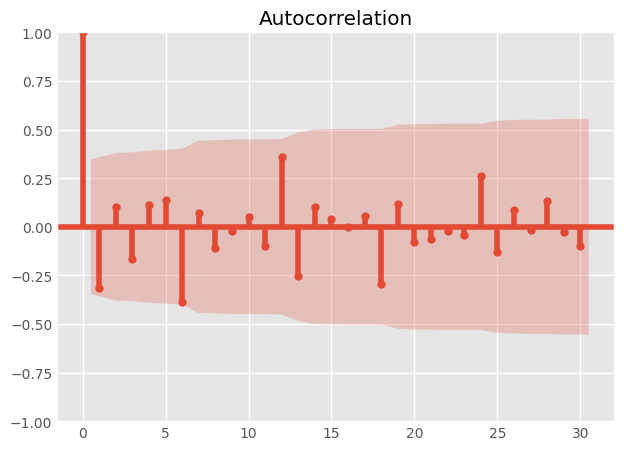

In [575]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('ggplot')
plot_acf(late_delivery_by_year_month, lags=30)

plt.savefig('acf.png', dpi=300)
plt.show()


c:\Users\mathe\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


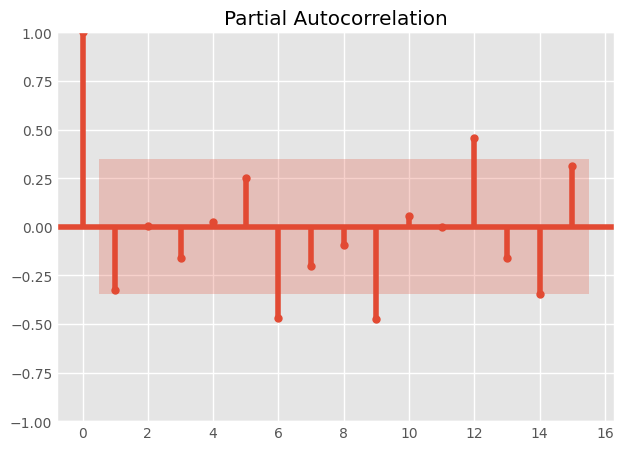

In [576]:
pacf_plot = plot_pacf(late_delivery_by_year_month, lags=15)
plt.savefig('pacf.png', dpi=300)
plt.show()


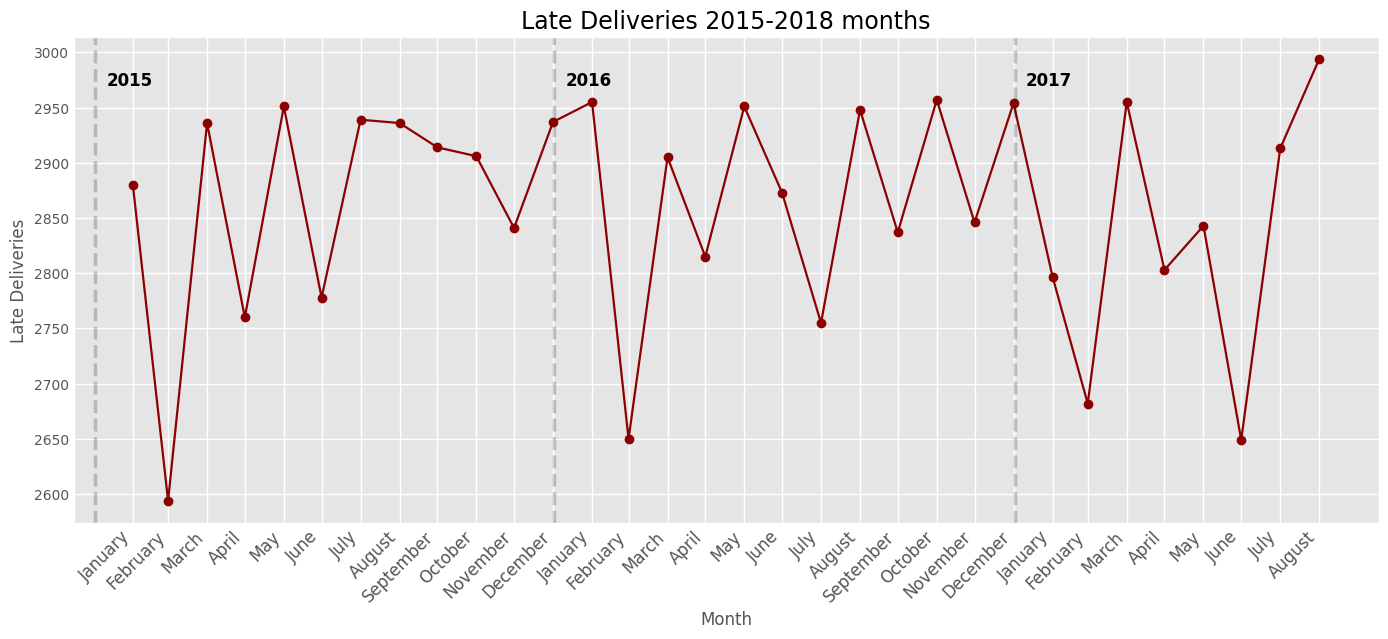

In [577]:
# plot late delivery by month date
plt.figure(figsize=(15, 6))
plt.plot(late_delivery_by_year_month.index, late_delivery_by_year_month.values, color='darkred', marker='o', linewidth=1.6, markersize=6)
plt.title('Late Deliveries 2015-2018 months', fontsize=17, loc='center')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Late Deliveries', fontsize=12)
# convert ticks to month name
plt.xticks(late_delivery_by_year_month.index, late_delivery_by_year_month.index.strftime('%B'), rotation=45, ha='right', fontsize=12)
# add another ticks to the top of the plot indicating the year

for year in range(2015, 2018):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2, linewidth=2.5)
    plt.annotate(year, xy=(pd.to_datetime(str(year)+'-01-10'), 2970), fontsize=12, fontweight='bold')


plt.savefig('late_delivery_by_year_month.png', dpi=300, bbox_inches='tight')
plt.show()



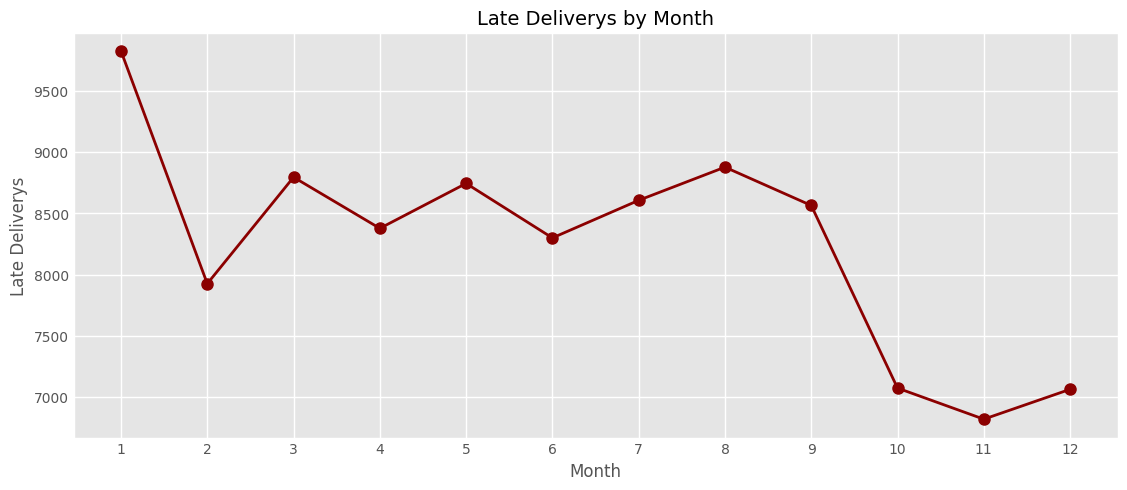

In [578]:
# plot time-series late deliverys by date
plt.figure(figsize=(12, 5))
late_delivery_by_month = data[data.late_delivery_risk == 1].groupby('order_month').size()
late_delivery_by_month

plt.plot(late_delivery_by_month.index, late_delivery_by_month.values, color='darkred', marker='o', linewidth=2, markersize=8)
plt.title('Late Deliverys by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Late Deliverys', fontsize=12)
plt.xticks(late_delivery_by_month.index)
plt.show()

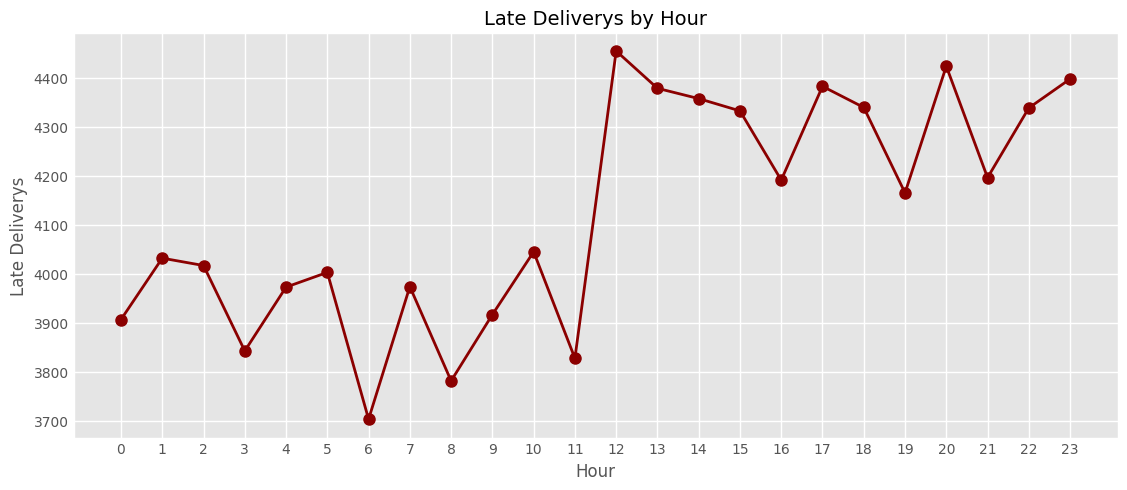

In [579]:
# late deliverys by hour
late_delivery_by_hour = data[data.late_delivery_risk == 1].groupby('order_hour').size()
late_delivery_by_hour

# plot time-series late deliverys by date
plt.figure(figsize=(12, 5))
plt.plot(late_delivery_by_hour.index, late_delivery_by_hour.values, color='darkred', marker='o', linewidth=2, markersize=8)
plt.title('Late Deliverys by Hour', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Late Deliverys', fontsize=12)
plt.xticks(late_delivery_by_hour.index)

plt.savefig('late_delivery_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()



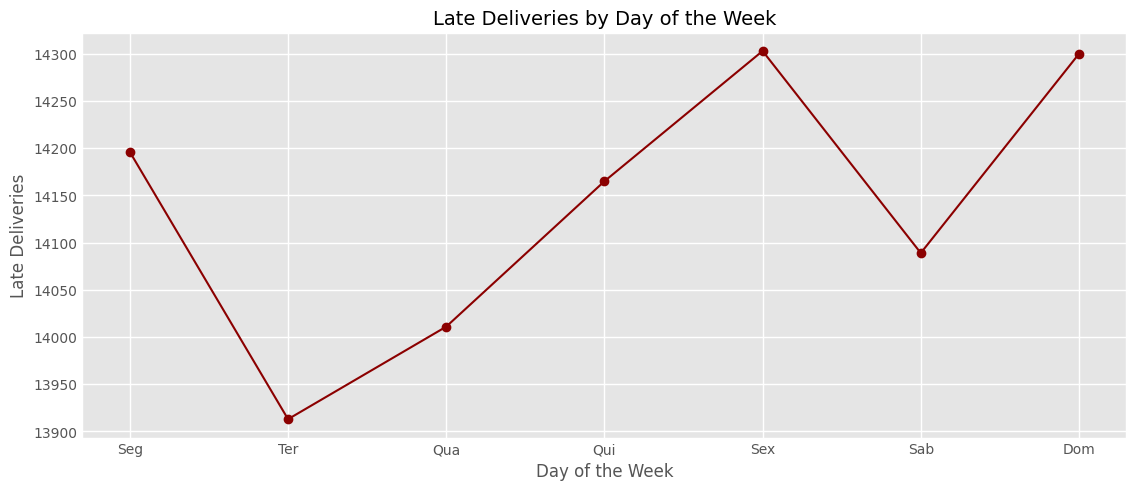

In [595]:
# number of late deliveries by day of the week
plt.figure(figsize=(12, 5))
data['order_day_of_week'] = data.order_date.dt.dayofweek
late_delivery_by_day = data[data.late_delivery_risk == 1].groupby('order_day_of_week').size()
late_delivery_by_day

plt.plot(late_delivery_by_day.index, late_delivery_by_day.values, color='darkred', marker='o', linewidth=1.5)
plt.title('Late Deliveries by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Late Deliveries', fontsize=12)
plt.xticks(late_delivery_by_day.index, ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])

plt.savefig('late_delivery_by_day_week.png', dpi=300, bbox_inches='tight')

plt.show()

In [722]:
features_of_interest = ['days_for_shipment_scheduled', 'customer_city', 'customer_country',
                       'product_name', 'category_name','shipping_mode', 'order_hour', 'order_day',
                       'order_month', 'order_year', 'order_date_dateorders']

target = 'late_delivery_risk'

data_ = data[features_of_interest + [target]]
data_ = data_.assign(order_date_dateorders=pd.to_datetime(data_.order_date_dateorders))
data_ = data_.sort_values(by='order_date_dateorders').reset_index(drop=True)

In [723]:
data_.order_date_dateorders.dtype

dtype('<M8[ns]')

In [726]:
late_delivery_by_year_month_copy['2017-08-31':] = None

year_month_mapper = (late_delivery_by_year_month_copy.reset_index().rename(columns={0: 'late_deliveries'})
).assign(
    year=late_delivery_by_year_month_copy.index.year, 
    month=late_delivery_by_year_month_copy.index.month).set_index(['year', 'month']).drop(columns='order_date')


In [727]:
# lag 6 months the year_month_mapper
six_months_behind = year_month_mapper.shift(6).to_dict()
twelve_months_behind = year_month_mapper.shift(12).to_dict()

In [728]:
# map the year and month to the number of late deliveries
data_ = data_.assign(late_deliveries_6_months_lag=data_.apply(lambda x: six_months_behind['late_deliveries'][(x.order_year, x.order_month)], axis=1),
                    late_deliveries_12_months_lag=data_.apply(lambda x: twelve_months_behind['late_deliveries'][(x.order_year, x.order_month)], axis=1))

In [729]:
data_['late_deliveries_6_months_lag'] = data_['late_deliveries_6_months_lag'].fillna(-1).astype(int)
data_['late_deliveries_12_months_lag'] = data_['late_deliveries_12_months_lag'].fillna(-1).astype(int)

## Modelagem
-----------

In [730]:
# time-series train test split
from sklearn.model_selection import train_test_split


X = data_.drop(columns=[target, 'order_date_dateorders'])
y = data_[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

X_train.shape, X_test.shape

((120935, 12), (51830, 12))

In [731]:
data_.tail(50)

,days_for_shipment_scheduled,customer_city,customer_country,product_name,category_name,shipping_mode,order_hour,order_day,order_month,order_year,order_date_dateorders,late_delivery_risk,late_deliveries_6_months_lag,late_deliveries_12_months_lag
172715,2,Caguas,Puerto Rico,Summer dresses,Women's Clothing,Second Class,5,31,1,2018,2018-01-31 05:46:00,1,2913,2797
172716,2,Greeley,EE. UU.,Summer dresses,Women's Clothing,Second Class,6,31,1,2018,2018-01-31 06:07:00,1,2913,2797
172717,4,Caguas,Puerto Rico,Summer dresses,Women's Clothing,Standard Class,6,31,1,2018,2018-01-31 06:28:00,1,2913,2797
172718,2,Hilliard,EE. UU.,Summer dresses,Women's Clothing,Second Class,6,31,1,2018,2018-01-31 06:49:00,0,2913,2797
172719,4,Caguas,Puerto Rico,Summer dresses,Women's Clothing,Standard Class,7,31,1,2018,2018-01-31 07:11:00,0,2913,2797
172720,4,Stone Mountain,EE. UU.,Summer dresses,Women's Clothing,Standard Class,7,31,1,2018,2018-01-31 07:32:00,0,2913,2797
172721,4,Los Angeles,EE. UU.,Summer dresses,Women's Clothing,Standard Class,7,31,1,2018,2018-01-31 07:53:00,1,2913,2797
172722,4,Caguas,Puerto Rico,Summer dresses,Women's Clothing,Standard Class,8,31,1,2018,2018-01-31 08:14:00,1,2913,2797
172723,4,Winnetka,EE. UU.,Summer dresses,Women's Clothing,Standard Class,8,31,1,2018,2018-01-31 08:35:00,0,2913,2797
172724,4,Caguas,Puerto Rico,Summer dresses,Women's Clothing,Standard Class,8,31,1,2018,2018-01-31 08:56:00,0,2913,2797


In [732]:
X_train.head(60)

,days_for_shipment_scheduled,customer_city,customer_country,product_name,category_name,shipping_mode,order_hour,order_day,order_month,order_year,late_deliveries_6_months_lag,late_deliveries_12_months_lag
0,4,Hickory,EE. UU.,Diamondback Women's Serene Classic Comfort Bi,Camping & Hiking,Standard Class,0,1,1,2015,-1,-1
1,4,Chicago,EE. UU.,Nike Men's Dri-FIT Victory Golf Polo,Women's Apparel,Standard Class,0,1,1,2015,-1,-1
2,4,Chicago,EE. UU.,Nike Men's CJ Elite 2 TD Football Cleat,Men's Footwear,Standard Class,0,1,1,2015,-1,-1
3,4,Chicago,EE. UU.,Pelican Sunstream 100 Kayak,Water Sports,Standard Class,0,1,1,2015,-1,-1
4,4,San Antonio,EE. UU.,O'Brien Men's Neoprene Life Vest,Indoor/Outdoor Games,Standard Class,1,1,1,2015,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
55,4,Miami,EE. UU.,Nike Men's CJ Elite 2 TD Football Cleat,Men's Footwear,Standard Class,5,1,1,2015,-1,-1
56,4,Miami,EE. UU.,Perfect Fitness Perfect Rip Deck,Cleats,Standard Class,5,1,1,2015,-1,-1
57,4,Hialeah,EE. UU.,Field & Stream Sportsman 16 Gun Fire Safe,Fishing,Standard Class,6,1,1,2015,-1,-1
58,4,Hialeah,EE. UU.,Diamondback Women's Serene Classic Comfort Bi,Camping & Hiking,Standard Class,6,1,1,2015,-1,-1


In [733]:
# pipeline for avoiding data leakage
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

# impute missing values
imputer = ColumnTransformer([])

# OrdinalEncoder encode categorical variables
ordinal_encoder = ColumnTransformer(
    [('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['customer_city', 'customer_country', 'product_name', 'category_name', 'shipping_mode'])], 
    remainder='passthrough'
    )

# pipeline
pipeline = Pipeline(
    steps=[
        ('ordinal_encoder', ordinal_encoder),
        ('imputer', SimpleImputer())
        ]
)

In [734]:
# model training
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, random_state=32, n_jobs=-1)

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

model.fit(X_train_transformed, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=32)

In [735]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 32,
 'verbose': 0,
 'warm_start': False}

In [736]:
# feature importance

feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importance

order_hour                       0.183725
order_day                        0.178130
days_for_shipment_scheduled      0.161719
shipping_mode                    0.135818
category_name                    0.125227
customer_country                 0.055532
product_name                     0.050493
order_month                      0.046475
late_deliveries_6_months_lag     0.027622
late_deliveries_12_months_lag    0.017084
customer_city                    0.013252
order_year                       0.004923
dtype: float64

In [737]:
# model evaluation

from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test_transformed)

print('roc_auc_score: ', roc_auc_score(y_test, y_pred))
print('average_precision_score: ', average_precision_score(y_test, y_pred))
print('precision_score: ', precision_score(y_test, y_pred))
print('recall_score: ', recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))


roc_auc_score:  0.7079970382193729
average_precision_score:  0.7109643434184737
precision_score:  0.7844238774602919
recall_score:  0.6558645625654715
f1_score:  0.7144066548881037


In [738]:
# time series cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

cv_performance = []

for train_index, test_index in tscv.split(X_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cv_transformed = pipeline.fit_transform(X_train_cv)
    X_test_cv_transformed = pipeline.transform(X_test_cv)

    model.fit(X_train_cv_transformed, y_train_cv)

    y_pred_cv = model.predict(X_test_cv_transformed)

    cv_performance.append(
        {
            'cv': f'{train_index[0]}:{train_index[-1]}',
            'roc_auc_score': roc_auc_score(y_test_cv, y_pred_cv),
            'average_precision_score': average_precision_score(y_test_cv, y_pred_cv),
            'precision_score': precision_score(y_test_cv, y_pred_cv),
            'recall_score': recall_score(y_test_cv, y_pred_cv),
            'f1_score': f1_score(y_test_cv, y_pred_cv)
        }
    )

cv_scores = pd.DataFrame.from_records(cv_performance).set_index('cv').sort_values(by='f1_score', ascending=False)

avg_scores = cv_scores.mean().to_dict()
std_scores = cv_scores.std().to_dict()

TRAIN: [    0     1     2 ... 10992 10993 10994] TEST: [10995 10996 10997 ... 21986 21987 21988]
TRAIN: [    0     1     2 ... 21986 21987 21988] TEST: [21989 21990 21991 ... 32980 32981 32982]
TRAIN: [    0     1     2 ... 32980 32981 32982] TEST: [32983 32984 32985 ... 43974 43975 43976]
TRAIN: [    0     1     2 ... 43974 43975 43976] TEST: [43977 43978 43979 ... 54968 54969 54970]
TRAIN: [    0     1     2 ... 54968 54969 54970] TEST: [54971 54972 54973 ... 65962 65963 65964]
TRAIN: [    0     1     2 ... 65962 65963 65964] TEST: [65965 65966 65967 ... 76956 76957 76958]
TRAIN: [    0     1     2 ... 76956 76957 76958] TEST: [76959 76960 76961 ... 87950 87951 87952]
TRAIN: [    0     1     2 ... 87950 87951 87952] TEST: [87953 87954 87955 ... 98944 98945 98946]
TRAIN: [    0     1     2 ... 98944 98945 98946] TEST: [ 98947  98948  98949 ... 109938 109939 109940]
TRAIN: [     0      1      2 ... 109938 109939 109940] TEST: [109941 109942 109943 ... 120932 120933 120934]


In [739]:
for metric in avg_scores.keys():
    print(f'{metric} avg: {avg_scores[metric]:.2f} +/- {std_scores[metric]:.2f}')

roc_auc_score avg: 0.70 +/- 0.01
average_precision_score avg: 0.70 +/- 0.02
precision_score avg: 0.77 +/- 0.03
recall_score avg: 0.68 +/- 0.03
f1_score avg: 0.72 +/- 0.01


## Predição

In [751]:
# prediction on test set

months_before = pd.concat((X_train, y_train), axis=1).groupby(['order_year', 'order_month']).late_delivery_risk.size()

predictions = pd.concat([X_test, y_test, pd.Series(y_pred, index=X_test.index)], axis=1).rename(columns={0: 'prediction'})
next_months = predictions.groupby(['order_year', 'order_month']).prediction.size().head(6)
next_months

order_year  order_month
2017        1              3978
            2              4675
            3              5145
            4              4980
            5              5035
            6              4730
Name: prediction, dtype: int64

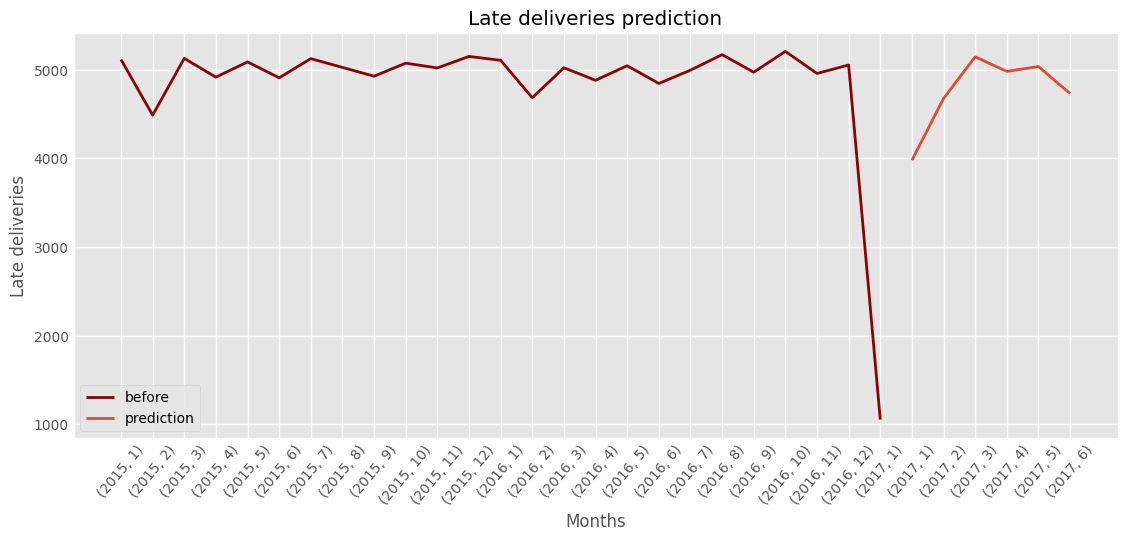

In [777]:
# plot the prediction with the other values

plt.figure(figsize=(12, 5))
plt.plot(range(0, len(months_before)), months_before.values, linewidth=2, color='darkred', label='before')
plt.plot(range(len(months_before), len(months_before) + len(next_months)), next_months.values, linewidth=2, label='prediction')

plt.title('Late deliveries prediction')
plt.xlabel('Months')
plt.ylabel('Late deliveries')

plt.xticks(range(0, len(months_before) + len(next_months)), months_before.index.append(next_months.index), rotation=50)

plt.legend()
plt.savefig('late_deliveries_prediction.png', dpi=300, bbox_inches='tight')
plt.show()


In [780]:
predictions.head(10)

,days_for_shipment_scheduled,customer_city,customer_country,product_name,category_name,shipping_mode,order_hour,order_day,order_month,order_year,late_deliveries_6_months_lag,late_deliveries_12_months_lag,late_delivery_risk,prediction
120935,4,Martinsburg,EE. UU.,Nike Men's Free 5.0+ Running Shoe,Cardio Equipment,Standard Class,18,7,1,2017,2755,2955,0,0
120936,4,Martinsburg,EE. UU.,Pelican Sunstream 100 Kayak,Water Sports,Standard Class,18,7,1,2017,2755,2955,0,0
120937,4,Martinsburg,EE. UU.,Perfect Fitness Perfect Rip Deck,Cleats,Standard Class,18,7,1,2017,2755,2955,0,0
120938,4,Martinsburg,EE. UU.,Glove It Women's Mod Oval Golf Glove,Golf Balls,Standard Class,18,7,1,2017,2755,2955,0,0
120939,4,Caguas,Puerto Rico,Field & Stream Sportsman 16 Gun Fire Safe,Fishing,Standard Class,18,7,1,2017,2755,2955,0,1
120940,4,Chino Hills,EE. UU.,Field & Stream Sportsman 16 Gun Fire Safe,Fishing,Standard Class,19,7,1,2017,2755,2955,0,0
120941,4,Chino Hills,EE. UU.,Nike Men's Dri-FIT Victory Golf Polo,Women's Apparel,Standard Class,19,7,1,2017,2755,2955,0,0
120942,4,Canton,EE. UU.,Nike Men's Dri-FIT Victory Golf Polo,Women's Apparel,Standard Class,19,7,1,2017,2755,2955,1,0
120943,4,Canton,EE. UU.,Diamondback Women's Serene Classic Comfort Bi,Camping & Hiking,Standard Class,19,7,1,2017,2755,2955,1,0
120944,2,Caguas,Puerto Rico,Nike Men's Dri-FIT Victory Golf Polo,Women's Apparel,Second Class,19,7,1,2017,2755,2955,1,1
